# 15 minutes to SEKV-E

This short introduction is aimed for potential and new users to get the feel of the software. This a Jupyter notebook that will execute some simple but important SEKV-E functions to run a dummy extraction process.

## Introduction

SEKV-E is a Python-based automated extractor for the simplified EKV (sEKV) model \cite{Enz2017a, Mangla2011}, which serves as a guideline for the low-power analog design with using MOSFET technologies \cite{Enz2017b}. In this short introduction, we will use the model `sekv.Model` with some random noise as a dummy transfer characteristic to test the extractor `sekve.Extractor`.

## Installation

SEKV-E is readily installed via pip or conda package managers 

Install via pip

> pip install sekve

Install via conda

> conda -c conda-forge install sekve


## Module imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sekve  # import the sekve module
from sekve.plotting import update_rcParams  # optional

update_rcParams()  # optional, update the matplotlib plotting style


## Model
`sekve.Model` is the simplified EKV model and contains the essential functions to model the transfer characteristics $I_D$-$V_G$ and current efficiency, or called transconductance efficiency, $G_m/I_D$.

The cell below passes a dummy inversion coefficient $IC$ from $10^{-3}$ to $10^2$ and a set of sEKV parameters to `sekve.Model` to generate the $I_D$-$V_G$ in saturation from weak to strong inversion. The sEKV parameters with corresponding symbols are shown in the table below. Besides, the noise ($\approx 2.5$ mV) is added to `dummy_VG` to test the capability of `sekve.Extractor`.

| Symbol     | Variable | Value |
|---         |---       |---    |
| $n$        | 'n'      | 1.2   |
| $I_{spec}$ | 'ispec'  | 650 nA|
| $V_{T0}$   | 'vt0'    | 0.4 V |
| $\lambda_c$| 'lambdac'| 0.2   |


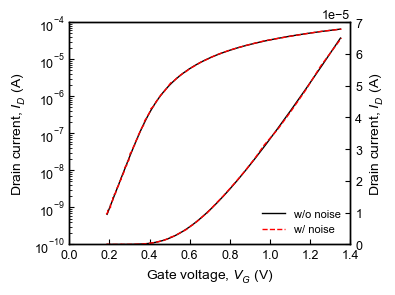

In [2]:
num = 80  # number of point
dummy_IC = np.logspace(-3, 2, num)  # generate a sequence of IC
dummy_ID = dummy_IC * 650e-9  # drain current is equal to the product of IC and specific current
dummy_VG = sekve.Model.model_ID_vs_VG(dummy_ID,
                                      n=1.2, ispec=650e-9, lambdac=0.2, vt0=0.4  # sEKV parameters 
                                     )

# Plot setting
ax = plt.gca()
ax2 = ax.twinx() # generate second y-axis
ax2.plot(dummy_VG, dummy_ID, 'k-')
ax.semilogy(dummy_VG, dummy_ID, 'k-', label="w/o noise")

noise = np.random.normal(0, 0.1*0.025, num)  # giving some noise 0.1 * kT
noise_VG = dummy_VG + noise
ax2.plot(noise_VG, dummy_ID, 'r--')
ax.semilogy(noise_VG, dummy_ID, 'r--', label="w/ noise")

ax.set_xlabel('Gate voltage, $V_G$ (V)')
ax.set_ylabel('Drain current, $I_D$ (A)')
ax2.set_ylabel("Drain current, $I_D$ (A)")


ax.legend(loc=4)
plt.tight_layout(pad=0.1);

## Extractor

There are two ways of running the extraction. The first one uses `sekve.Extractor`. This method returns a instance of `sekve.Extractor` that contains the detailed extraction result.

```python 
res = sekve.Extractor(
    vg=vg_data,
    i=id_data,
    **kwargs  # parameters setting the options of the extractor
)
res.run_extraction()  # Execute the extraction

sekv_params = res.ekv_4params  # return a dict containing sEKV parameters for modeling the transfer characteristics
```

The second method uses a higher level function and simples returns sEKV parameters.

```python

n, ispec, lambdac, vt0 = sekve.extract_idvg(
    vg=vg_data,
    i=id_data,
    return_detail=False,  # If True, the function returns the instance of `sekve.Extractor`
    exp_dict={...}  # a dict passed to `sekve.Extractor` setting the options of the extractor
)
```
If `return_detail=True`, `sekve.extract_idvg` returns an instance of `sekve.Extractor`. The optional variables that set the extractor can be passed via `exp_dict`.  

The following examples demonstrate both methods.

### Dummy extraction without noise

The next cell extracts the dummy test generated from `sekve.Model` without adding any noise. Transfer characteristic is simply passed to `sekve.Extractor` to initialize the module.

In [3]:
res = sekve.Extractor(vg=dummy_VG,
                      i=dummy_ID,
                     )
res.run_extraction()  # Execute the extraction

The next cell presents the process of the extraction, which can be used to debug or justify the extraction. The detail process is presented in \cite{Han2022}

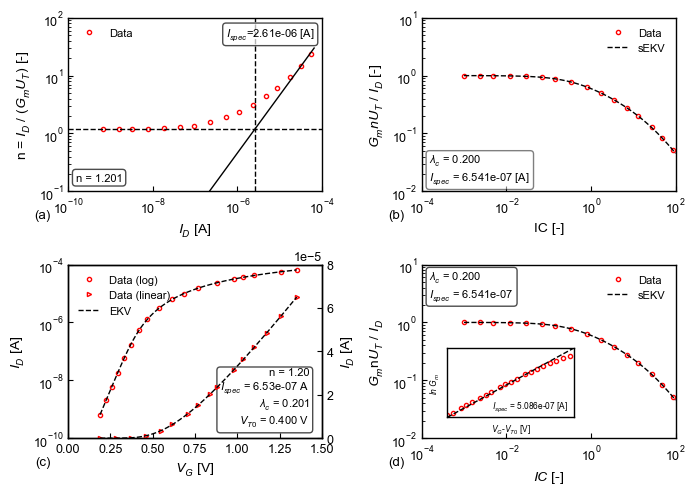

In [4]:
_ = res.progress_fig

The cell below plots the final result from `Extractor`. The extracted parameters with the error smaller than 1 % justify the extraction methodology.

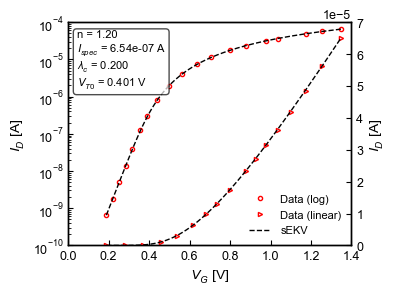

In [5]:
_ = res.final_fig

## Dummy extraction with noise

In [6]:
# using another method to run the extraction
res = sekve.extract_idvg(vg=noise_VG, i=dummy_ID, return_detail=True)

The figure below shows the extraction process on the noisy transfer characteristic, where the extractor nicely handles the fluctuation that is pronounced in the small signal.

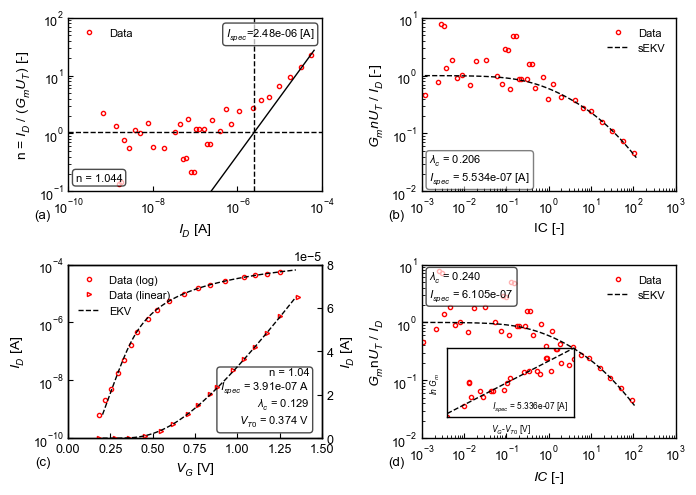

In [7]:
_ = res.progress_fig

In [8]:
_ = res.final_fig

The above figure shows the model successfully compares to the fluctuating transfer characteristic.

## Real case

In [9]:
# read data
df = pd.read_csv('data/short_channel_idvg_high_vds.csv')

ax = plt.gca()
ax2 = ax.twinx()
ax.semilogy(df.VG.values, df.ID.values)
ax2.plot(df.VG.values, df.ID.values)
ax.set_xlabel('Gate voltage, $V_G$ (V)')
ax.set_ylabel('Drain current, $I_D$ (A)')
ax2.set_ylabel("Drain current, $I_D$ (A)");

The measurement data shows that the transfer characteristic behaves linearly above the threshold voltage. Besides, the high $V_G$ degrades the transconductance due to the vertical-field induced mobility reduction. The evidence suggests the extremely-short-channel transistor. However, some operation regions are excluded by the sEKV model to keep the simplicity, such as accumulation region and the mobility-degraded region. Therefore, `sekve.Extractor` has implemented the functions to define the operation region that will be analyzed in the algorithm. For instant, `remove_mobility_reduction=True` is set by default to get rid off the region with degraded mobility, which is usually in deep strong inversion.

The parameter `vth_tol` is a tolerance when extractor fine tune the `Ispec` from the subthreshold region. If the subthreshold data points are sufficient, clean, and reasonably linear, you can set `vth_tol=0` or close to 0. if not, you can set the number around `vth_tol=0.02`. For further information, please check the IEEE open journal of Circuits and Systems paper \cite{Han2022}.

In [10]:
res = sekve.extract_idvg(
    i=df.ID.values,
    vg=df.VG.values,
    return_detail=True,
    ext_dict={
        'remove_mobility_reduction': True,  # get rid of region with mobility degradation due to vertical field
        'force_lambdac_0': False,  # If True, lambdac is forced to be zero.
        'vth_tol': 0.02,
    }                 
)

It is recommended to set `force_lambdac_0=False` for sub-micron transistors. For long transistors, `force_lambdac_0=True` can be used. In this case, the `lambdac` won't be extracted but will be forced to zero. However, the presence of mobility degradation at high $V_G$ due to a strong vertical field results in non-quadratic behavior for long devices or non-linear behavior for short devices. In this scenario, `remove_mobility_reduction=True` should be set. Otherwise, it will end up with the large `lambdac` and `Ispec`. 

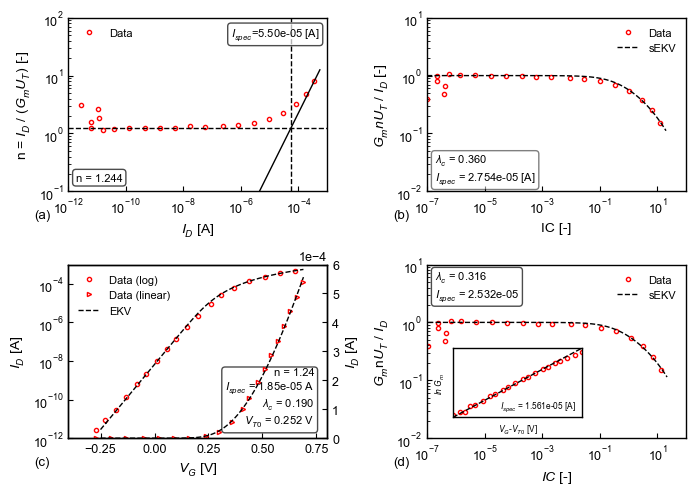

In [11]:
_ = res.progress_fig

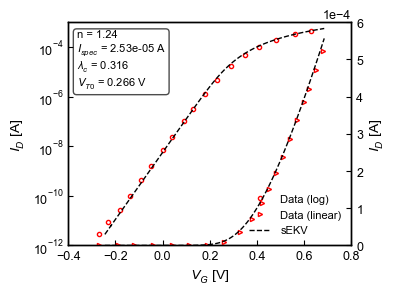

In [12]:
_ = res.final_fig

To get the extracted parameters in a dict

In [13]:
res.ekv_4params

{'n': 1.2438190616270433,
 'ispec': 2.5322694326109732e-05,
 'lambdac': 0.31648047412858127,
 'vt0': 0.2659215943954934}

 or in Pandas DataFrame

In [14]:
res.ekv_4params_to_pandas(index=['short nMOS device'])

n     ispec  lambdac       vt0
short nMOS device  1.243819  0.000025  0.31648  0.265922

The figure below shows the comparison between the measurement and sEKV model.

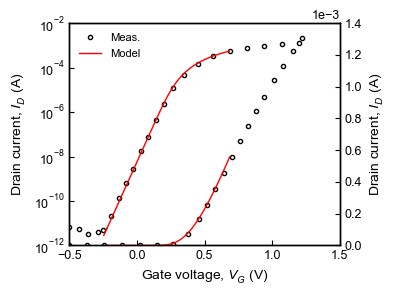

In [15]:
ax = plt.gca()
ax2 = ax.twinx()
ax.semilogy(df.VG.values, df.ID.values, marker="o", ls="", label='Meas.')
ax2.plot(df.VG.values, df.ID.values, marker="o", ls="")

ax.semilogy(res.VG_m, res.ID, 'r-', label="Model")
ax2.plot(res.VG_m, res.ID, "r-")

ax.set_xlabel('Gate voltage, $V_G$ (V)')
ax.set_ylabel('Drain current, $I_D$ (A)')
ax2.set_ylabel("Drain current, $I_D$ (A)");

ax.legend()

It should be noted that the model stops at $V_G\approx 0.7$ V. This is because the high-$V_G$ region with the degraded mobility is excluded. It also suggests that the transistor should not be biased in deep strong inversion, where the current efficiency is substantially reduced, as shown below.

In [16]:
ax = plt.gca()

model = sekve.Model.model_gms_over_IC_vs_IC(i=df.ID.values, lambdac=res.lambdac, ispec=res.Ispec)
meas = np.gradient(df.ID.values, df.VG.values)/df.ID.values*res.n*res.Ut

ic = df.ID.values/res.Ispec
ax.loglog(ic, model, 'r-', label='sEKV model')
ax.loglog(ic, meas, 'ko', label='Measurement')
ax.set_ylim(0.01, 2)
ax.set_xlim(1e-3, 1e2)

ax.annotate('Mobiltiy degradation region', (45, 0.04), (0.05, 0.04), arrowprops=dict(arrowstyle='->'))
ax.legend(loc=0)
ax.set_xlabel('Inversion coefficient, $IC$ (-)')
ax.set_ylabel(r'Current efficiency, $\frac{g_{ms}}{IC}=\frac{G_m n U_T}{I_D}$ (-)');

## References

[<a id="cit-Enz2017a" href="#call-Enz2017a">1</a>] Enz Christian, Chicco Francesco and Pezzotta Alessandro, ``_Nanoscale MOSFET Modeling: Part 1: The Simplified EKV Model for the Design of Low-Power Analog Circuits_'', SSC-M, vol. 9, number 3, pp. 26-35,  2017.

[<a id="cit-Mangla2011" href="#call-Mangla2011">2</a>] A. Mangla, C.C. Enz and J. Sallese, ``_Figure-of-merit for optimizing the current-efficiency of low-power RF circuits_'', MIXDES,  2011.

[<a id="cit-Enz2017b" href="#call-Enz2017b">3</a>] Enz Christian, Chicco Francesco and Pezzotta Alessandro, ``_Nanoscale MOSFET Modeling: Part 2: Using the Inversion Coefficient as the Primary Design Parameter_'', SSC-M, vol. 9, number 4, pp. 73-81,  2017.

[<a id="cit-Han2022" href="#call-Han2022">4</a>] Han Hung-Chi, D’Amico Antonio and Enz Christian, ``_SEKV-E: Parameter Extractor of Simplified EKV I-V Model for Low-Power Analog Circuits_'', IEEE Open Journal of Circuits and Systems, vol. 3, pp. 162-167,  2022.

